1. Data Generation

Since you'll be training a model, you'll need example sinusoidal wave data. Here's how to generate it:

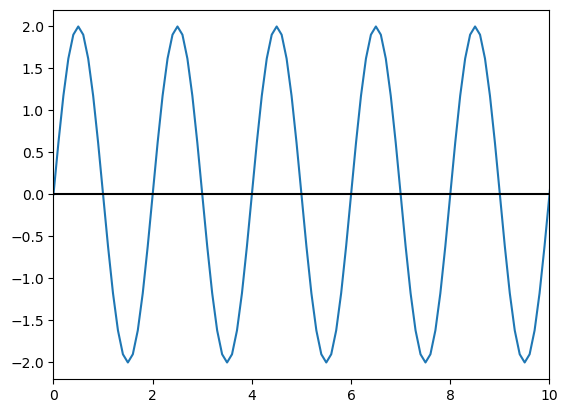

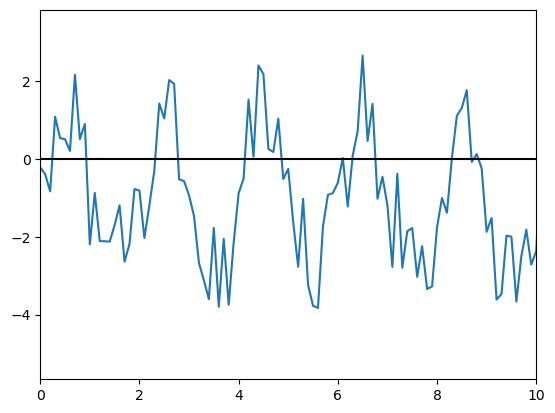

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wave(amplitude, frequency, phase, duration, sampling_rate):
    time = np.arange(0, duration, 1/sampling_rate)
    wave = amplitude * np.sin(2 * np.pi * frequency * time + phase)
    return time, wave

# Example usage
time, wave = generate_wave(amplitude=2, frequency=0.5, phase=0, 
                           duration=100, sampling_rate=10) 
plt.plot(time, wave)
plt.axhline(y=0, color='k')
plt.xlim(0, 10)
plt.show()

# add random noise
noise = np.random.normal(-1, 1, len(wave))
wave_with_noise = wave + noise
plt.plot(time, wave_with_noise)
plt.axhline(y=0, color='k')
plt.xlim(0, 10)
plt.show()

2. Creating Labels

You'll need labels (positive or negative) corresponding to the wave polarity after 20 seconds:

In [5]:
def get_polarity(wave, time, target_time=20):
    target_index = np.argmin(abs(time - target_time))
    return 1 if wave[target_index] >= 0 else 0  # 1 for positive, 0 for negative

3. PyTorch Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


4.  Model Definition

A simple neural network will suffice for this task. Consider a recurrent architecture like an LSTM:

In [7]:
class PolarityPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, 1)  # 1 output: positive (1), negative (0)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.output_layer(lstm_out[:, -1, :])  # Get output at last time step
        return out


5. Training Loop

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# m1 macboook pro arm architecture gpu
# device = torch.device("cuda:0")  
model = PolarityPredictor(input_size=1, hidden_size=32, num_layers=2).to(device) 
loss_fn = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters())

for epoch in range(100):  # Adjust number of epochs
    # Generate random data, get labels
    amplitude = np.random.uniform(0.5, 3)
    frequency = np.random.uniform(0.1, 10)
    phase = np.random.uniform(0, 2 * np.pi) # 0 to 2pi
    duration = 100 # seconds
    sampling_rate = 10  # Hz

    time, wave = generate_wave(amplitude, frequency, phase, duration, sampling_rate) #

    # select a random time point to get the label
    target_time = np.random.uniform(0, duration)
    label = get_polarity(wave, target_time)

    wave_tensor = torch.tensor(wave).unsqueeze(0).unsqueeze(-1).float().to(device)  
    label_tensor = torch.tensor(label).float().to(device) 

    output = model(wave_tensor)
    loss = loss_fn(output, label_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


ValueError: Target size (torch.Size([])) must be the same as input size (torch.Size([1, 1]))